In [0]:
#imports cell 
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Input,Flatten,GlobalAveragePooling2D,Dropout,InputLayer,GlobalAveragePooling3D,Reshape,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
K.set_image_data_format("channels_first")

### Mount the Google Drive to Google Colab

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Method for Loading dataset into Memory

In [0]:
def load_data(view,symptom,base_model,model_gap):
    train_X = np.load('/content/gdrive/My Drive/Dataset/Transformations/interpolated24_train_' + view + '.npy')
    valid_X = np.load('/content/gdrive/My Drive/Dataset/Transformations/interpolated24_valid_' + view + '.npy')
    train_Y = np.genfromtxt('/content/gdrive/My Drive/Dataset/MRNet-v1.0/train-' + symptom + '.csv',delimiter=',')[:,1]
    valid_Y = np.genfromtxt('/content/gdrive/My Drive/Dataset/MRNet-v1.0/valid-' + symptom + '.csv',delimiter=',')[:,1]
    train_X=np.stack([train_X]*3,axis=2)
    valid_X=np.stack([valid_X]*3,axis=2)
    
    ##feature extraction and passing data to GAP layer
    new_train_X = np.zeros(shape=(1130,24,512))
    for i in range(1130):
      first_output=base_model.predict(train_X[i])
      new_train_X[i] = model_gap.predict(first_output)
    train_X = None

    
    new_valid_X = np.zeros(shape=(120,24,512))
    for i in range(120):
      first_output=base_model.predict(valid_X[i])
      new_valid_X[i] = model_gap.predict(first_output)
    valid_X = None
    
    new_train_X=new_train_X.reshape(1130,512,24,1)
    new_valid_X=new_valid_X.reshape(120,512,24,1)
    return new_train_X,train_Y,new_valid_X,valid_Y
    

## Build Model

In [0]:
def build_model():
  #feature extractor
  base_model = VGG16(weights='imagenet',input_shape=(3,256,256),include_top=False,input_tensor=Input(shape=(3,256,256)))
  #Global Average Pooling
  inputs=Input(shape=(512,8,8))
  gap=GlobalAveragePooling2D()(inputs)
  model_gap=Model(inputs=inputs,outputs=gap)
  #Final Model
  inputs=Input(shape=(512,24,1))
  batch_norm = BatchNormalization()(inputs)
  max_pooling=MaxPooling2D(1,24)(batch_norm)
  flatten = Flatten()(max_pooling)
  model = Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001))(flatten)
  model = Dropout(0.5)(model)
  model = Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001))(model)
  model = Dropout(0.5)(model)
  pred = Dense(1,activation='sigmoid')(model)
  model_final=Model(inputs=inputs,outputs=pred)
  
  model_final.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
  return base_model,model_gap,model_final

def show_model(model):
  model.summary()
  
def train_model(model,plane,label):
  base_model,model_gap,model = build_model()
  train_X,train_y,val_X,val_y = load_data(plane,label,base_model,model_gap)
  mc = ModelCheckpoint('/content/gdrive/My Drive/Models/PaperImplementation/'+plane+'_'+label+'.h5', monitor='val_acc', mode='max', verbose=2, save_best_only=True)
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=5)
  history = model.fit(x=train_X, y=train_y,  validation_data=(val_X,val_y), batch_size = 20, epochs=50,verbose=2, callbacks=[mc,es])
  return history


def plot_history(histories, key='acc'):
  plt.figure(figsize=(16,10))
  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val',color='b')
    plt.plot(history.epoch, history.history[key], color='b',
             label=name.title()+' Train')
  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()
  plt.ylim([0,1])
  plt.xlim([0,max(history.epoch)])
  plt.figure(0)
  plt.show()
  
  plt.figure(figsize=(16,10))
  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_loss'],
                   '--', label=name.title()+' Val',color='r')
    plt.plot(history.epoch, history.history['loss'], color='r',
             label=name.title()+' Train')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.ylim([0,1.5])
  plt.xlim([0,max(history.epoch)])
  plt.show()

# Let's Begin Training the Net

## Model 1: Axial Plane and ACL Labels

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 1130 samples, validate on 120 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/50

Epoch 00001: val_acc improved from -inf to 0.55000, saving model to /content/gdrive/My Drive/Models/PaperImplementation/axial_acl.h5
 - 2s - loss: 0.7401 - acc: 0.7850 - val_loss: 0.9998 - val_acc: 0.5500
Epoch 2/50

Epoch 00002: val_acc did not improve from 0.55000
 - 0s - loss: 0.6412 - acc: 0.8080 - val_loss: 0.9661 - val_acc: 0.5500
Epoch 3/50

Epoch 00003: val_acc did not improve from 0.55000
 - 0s - loss: 0.6161 - acc: 0.8106 - val_loss: 1.0016 - val_acc: 0.5500
Epoch 4/50

Epoch 00004: val_acc did not improve from 0.55000
 - 0s - loss: 0.5835 - acc: 0.8124 - val_loss: 0.8146 - val_acc: 0.5500
Epoch 5/50

Epoch 00005: val_acc did not improve from 0.55000
 - 0s - loss: 0.5636 - acc: 0.8159 - 

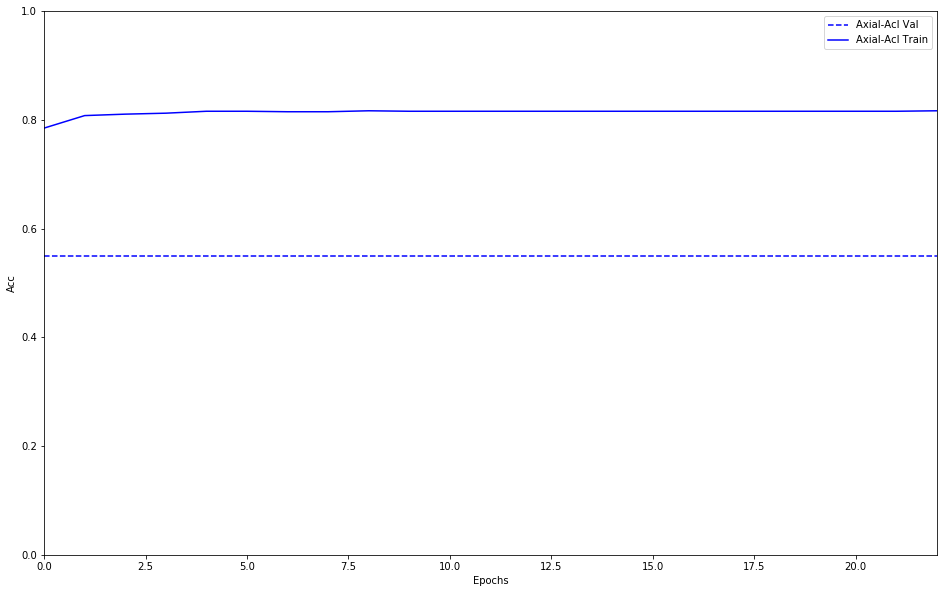

<Figure size 432x288 with 0 Axes>

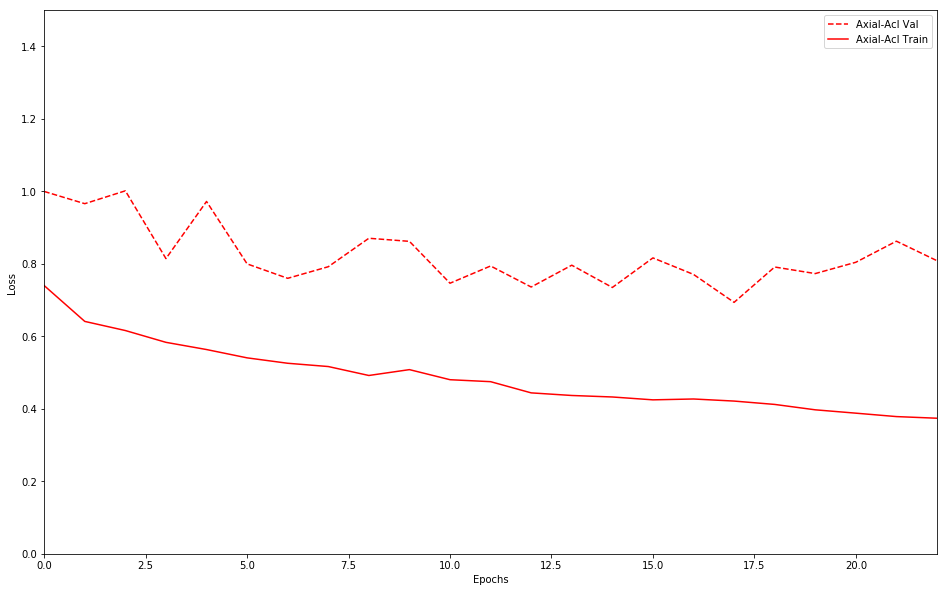

In [5]:
model = build_model()
history = train_model(model,"axial","acl")
plot_history([('Axial-ACL',history)])

## Model 2: Axial Plane and Abnormal Labels

Train on 1130 samples, validate on 120 samples
Epoch 1/50

Epoch 00001: val_acc improved from -inf to 0.79167, saving model to /content/gdrive/My Drive/Models/PaperImplementation/axial_abnormal.h5
 - 1s - loss: 0.6978 - acc: 0.7699 - val_loss: 0.8786 - val_acc: 0.7917
Epoch 2/50

Epoch 00002: val_acc did not improve from 0.79167
 - 0s - loss: 0.5593 - acc: 0.8062 - val_loss: 0.7609 - val_acc: 0.7917
Epoch 3/50

Epoch 00003: val_acc did not improve from 0.79167
 - 0s - loss: 0.5393 - acc: 0.8106 - val_loss: 0.6718 - val_acc: 0.7917
Epoch 4/50

Epoch 00004: val_acc did not improve from 0.79167
 - 0s - loss: 0.4968 - acc: 0.8186 - val_loss: 0.7258 - val_acc: 0.7917
Epoch 5/50

Epoch 00005: val_acc did not improve from 0.79167
 - 0s - loss: 0.4787 - acc: 0.8177 - val_loss: 0.7333 - val_acc: 0.7917
Epoch 6/50

Epoch 00006: val_acc improved from 0.79167 to 0.80000, saving model to /content/gdrive/My Drive/Models/PaperImplementation/axial_abnormal.h5
 - 0s - loss: 0.4557 - acc: 0.8292 - val_l

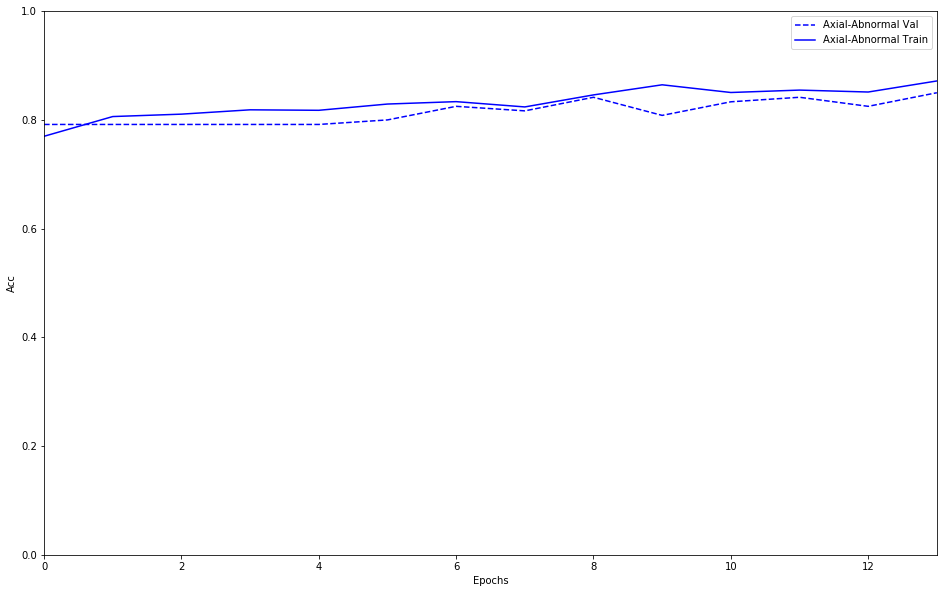

<Figure size 432x288 with 0 Axes>

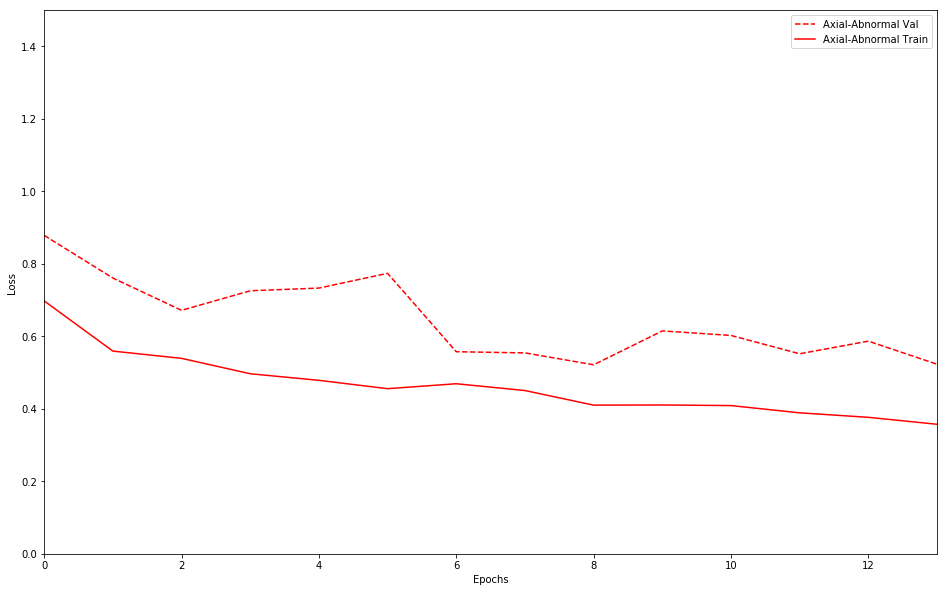

In [6]:
model = build_model()
history = train_model(model,"axial","abnormal")
plot_history([('Axial-Abnormal',history)])

## Model 3: Axial Plane and Meniscus Labels

Train on 1130 samples, validate on 120 samples
Epoch 1/50

Epoch 00001: val_acc improved from -inf to 0.57500, saving model to /content/gdrive/My Drive/Models/PaperImplementation/axial_meniscus.h5
 - 1s - loss: 0.9030 - acc: 0.5761 - val_loss: 0.8250 - val_acc: 0.5750
Epoch 2/50

Epoch 00002: val_acc improved from 0.57500 to 0.59167, saving model to /content/gdrive/My Drive/Models/PaperImplementation/axial_meniscus.h5
 - 0s - loss: 0.7880 - acc: 0.6416 - val_loss: 0.7952 - val_acc: 0.5917
Epoch 3/50

Epoch 00003: val_acc did not improve from 0.59167
 - 0s - loss: 0.7404 - acc: 0.6735 - val_loss: 0.7698 - val_acc: 0.5833
Epoch 4/50

Epoch 00004: val_acc improved from 0.59167 to 0.63333, saving model to /content/gdrive/My Drive/Models/PaperImplementation/axial_meniscus.h5
 - 0s - loss: 0.7134 - acc: 0.6655 - val_loss: 0.7643 - val_acc: 0.6333
Epoch 5/50

Epoch 00005: val_acc improved from 0.63333 to 0.69167, saving model to /content/gdrive/My Drive/Models/PaperImplementation/axial_menisc

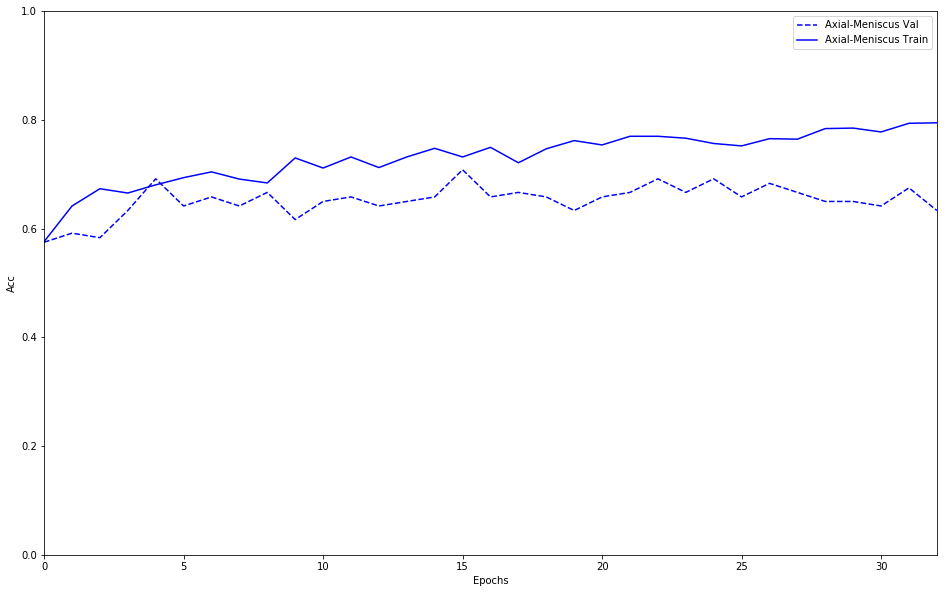

<Figure size 432x288 with 0 Axes>

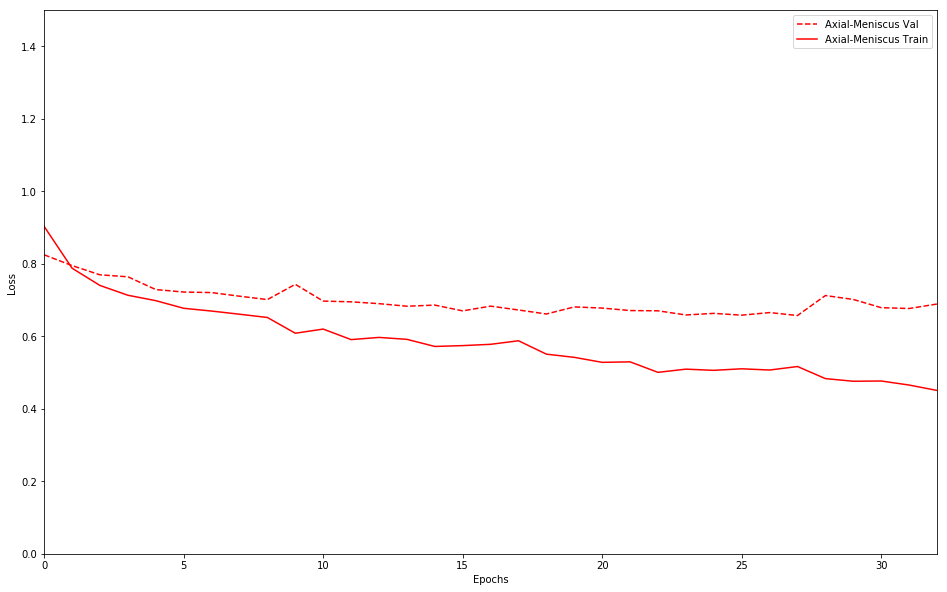

In [7]:
model = build_model()
history = train_model(model,"axial","meniscus")
plot_history([('Axial-Meniscus',history)])

## Model 4: Coronol Plane and ACL Labels

Train on 1130 samples, validate on 120 samples
Epoch 1/50

Epoch 00001: val_acc improved from -inf to 0.55000, saving model to /content/gdrive/My Drive/Models/PaperImplementation/coronal_acl.h5
 - 2s - loss: 0.7360 - acc: 0.7434 - val_loss: 1.2185 - val_acc: 0.5500
Epoch 2/50

Epoch 00002: val_acc did not improve from 0.55000
 - 0s - loss: 0.6512 - acc: 0.8106 - val_loss: 1.1121 - val_acc: 0.5500
Epoch 3/50

Epoch 00003: val_acc did not improve from 0.55000
 - 0s - loss: 0.6127 - acc: 0.8133 - val_loss: 0.9209 - val_acc: 0.5500
Epoch 4/50

Epoch 00004: val_acc did not improve from 0.55000
 - 0s - loss: 0.5886 - acc: 0.8097 - val_loss: 0.8815 - val_acc: 0.5500
Epoch 5/50

Epoch 00005: val_acc did not improve from 0.55000
 - 0s - loss: 0.5659 - acc: 0.8150 - val_loss: 0.8853 - val_acc: 0.5500
Epoch 6/50

Epoch 00006: val_acc did not improve from 0.55000
 - 0s - loss: 0.5347 - acc: 0.8150 - val_loss: 0.8665 - val_acc: 0.5500
Epoch 7/50

Epoch 00007: val_acc did not improve from 0.55000
 -

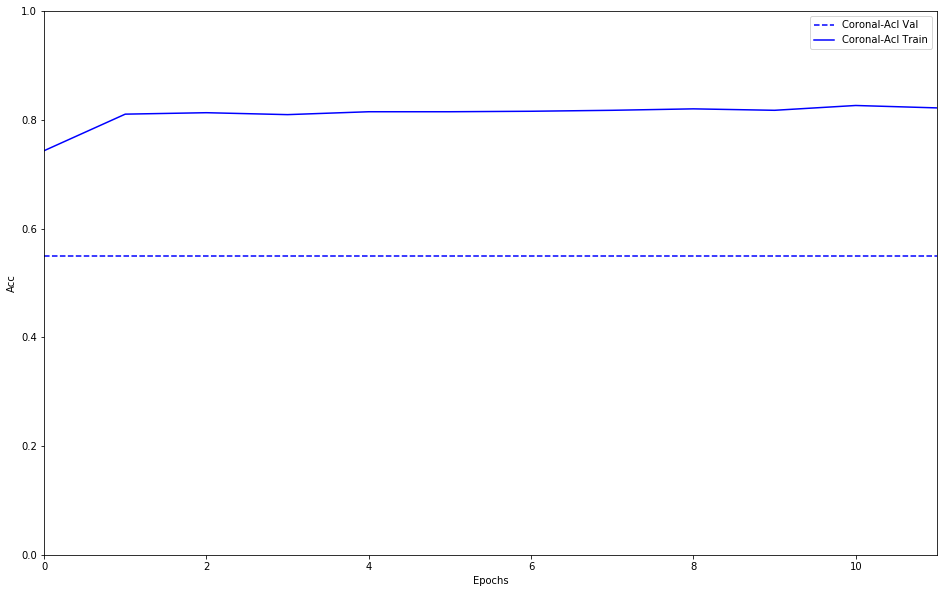

<Figure size 432x288 with 0 Axes>

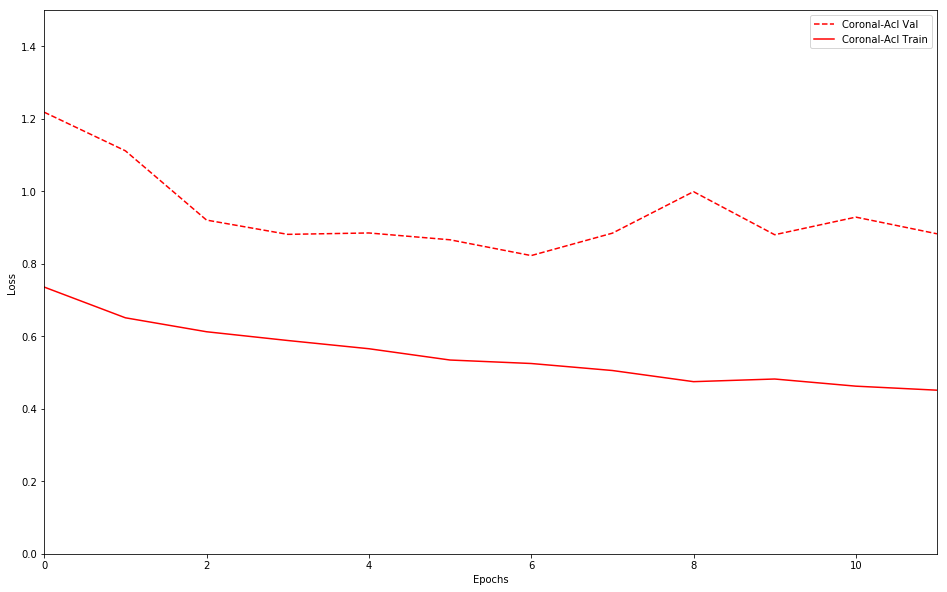

In [8]:
model = build_model()
history = train_model(model,"coronal","acl")
plot_history([('Coronal-ACL',history)])

## Model 5: Coronol Plane and Abnormal Labels

Train on 1130 samples, validate on 120 samples
Epoch 1/50

Epoch 00001: val_acc improved from -inf to 0.79167, saving model to /content/gdrive/My Drive/Models/PaperImplementation/coronal_abnormal.h5
 - 2s - loss: 0.7527 - acc: 0.7619 - val_loss: 0.6683 - val_acc: 0.7917
Epoch 2/50

Epoch 00002: val_acc did not improve from 0.79167
 - 0s - loss: 0.6374 - acc: 0.8027 - val_loss: 0.6812 - val_acc: 0.7917
Epoch 3/50

Epoch 00003: val_acc improved from 0.79167 to 0.80000, saving model to /content/gdrive/My Drive/Models/PaperImplementation/coronal_abnormal.h5
 - 0s - loss: 0.5922 - acc: 0.7982 - val_loss: 0.6317 - val_acc: 0.8000
Epoch 4/50

Epoch 00004: val_acc did not improve from 0.80000
 - 0s - loss: 0.5674 - acc: 0.8088 - val_loss: 0.6230 - val_acc: 0.7833
Epoch 5/50

Epoch 00005: val_acc did not improve from 0.80000
 - 0s - loss: 0.5383 - acc: 0.8159 - val_loss: 0.6245 - val_acc: 0.8000
Epoch 6/50

Epoch 00006: val_acc improved from 0.80000 to 0.80833, saving model to /content/gdrive/M

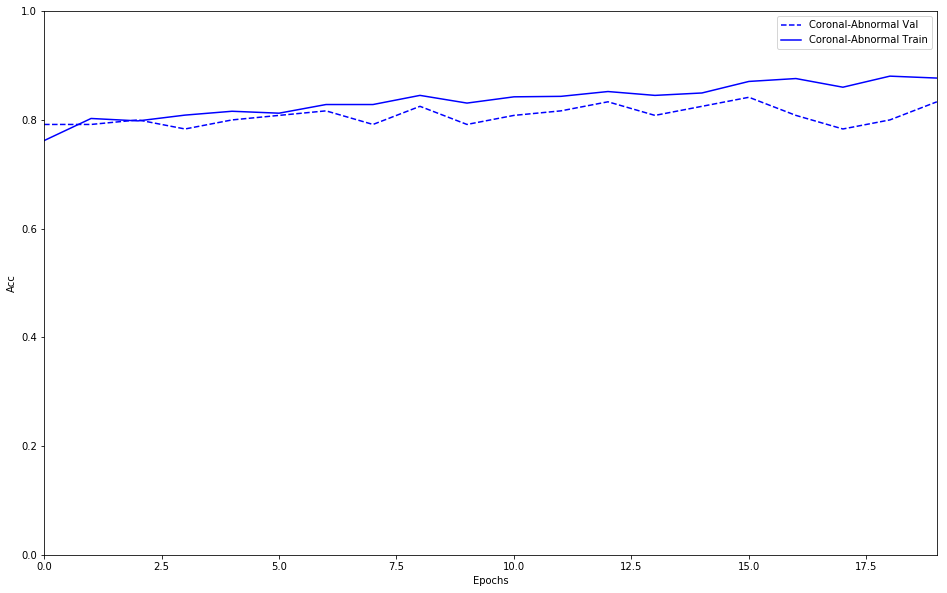

<Figure size 432x288 with 0 Axes>

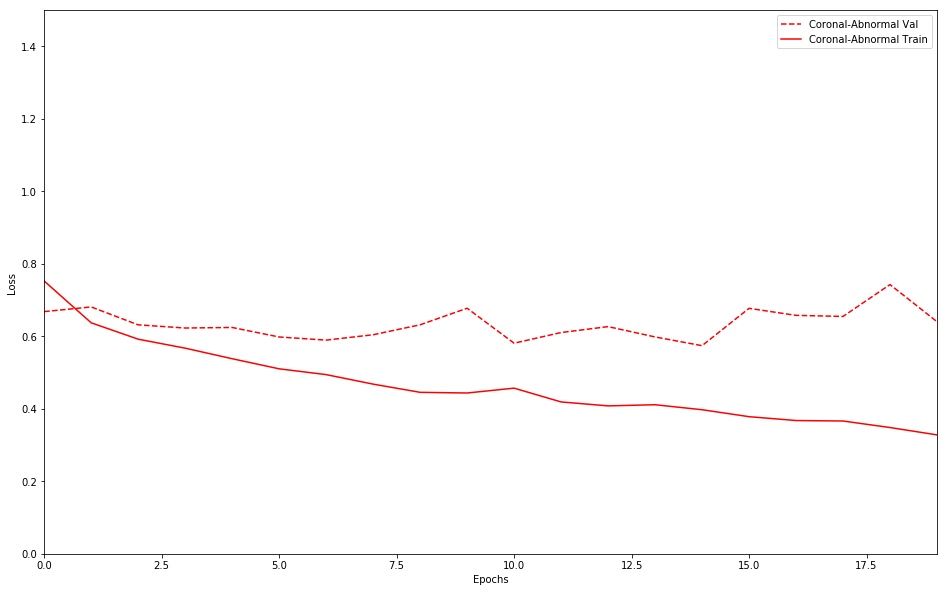

In [9]:
model = build_model()
history = train_model(model,"coronal","abnormal")
plot_history([('Coronal-Abnormal',history)])

## Model 6: Coronol Plane and Meniscus Labels

Train on 1130 samples, validate on 120 samples
Epoch 1/50

Epoch 00001: val_acc improved from -inf to 0.56667, saving model to /content/gdrive/My Drive/Models/PaperImplementation/coronal_meniscus.h5
 - 3s - loss: 0.8884 - acc: 0.5876 - val_loss: 0.8742 - val_acc: 0.5667
Epoch 2/50

Epoch 00002: val_acc improved from 0.56667 to 0.64167, saving model to /content/gdrive/My Drive/Models/PaperImplementation/coronal_meniscus.h5
 - 0s - loss: 0.7960 - acc: 0.6124 - val_loss: 0.7869 - val_acc: 0.6417
Epoch 3/50

Epoch 00003: val_acc did not improve from 0.64167
 - 0s - loss: 0.7601 - acc: 0.6708 - val_loss: 0.7696 - val_acc: 0.5917
Epoch 4/50

Epoch 00004: val_acc improved from 0.64167 to 0.65000, saving model to /content/gdrive/My Drive/Models/PaperImplementation/coronal_meniscus.h5
 - 0s - loss: 0.7440 - acc: 0.6832 - val_loss: 0.7623 - val_acc: 0.6500
Epoch 5/50

Epoch 00005: val_acc improved from 0.65000 to 0.65833, saving model to /content/gdrive/My Drive/Models/PaperImplementation/corona

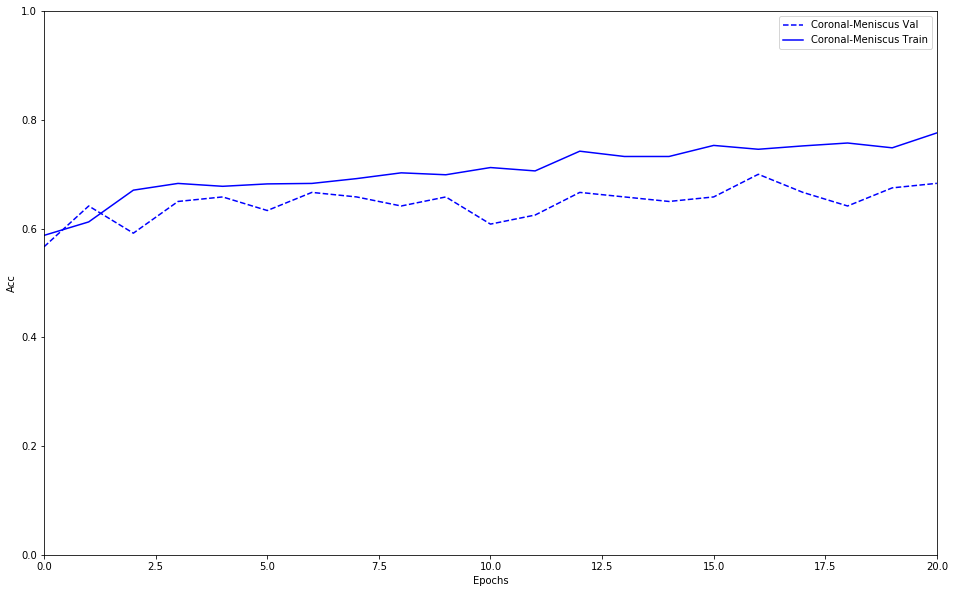

<Figure size 432x288 with 0 Axes>

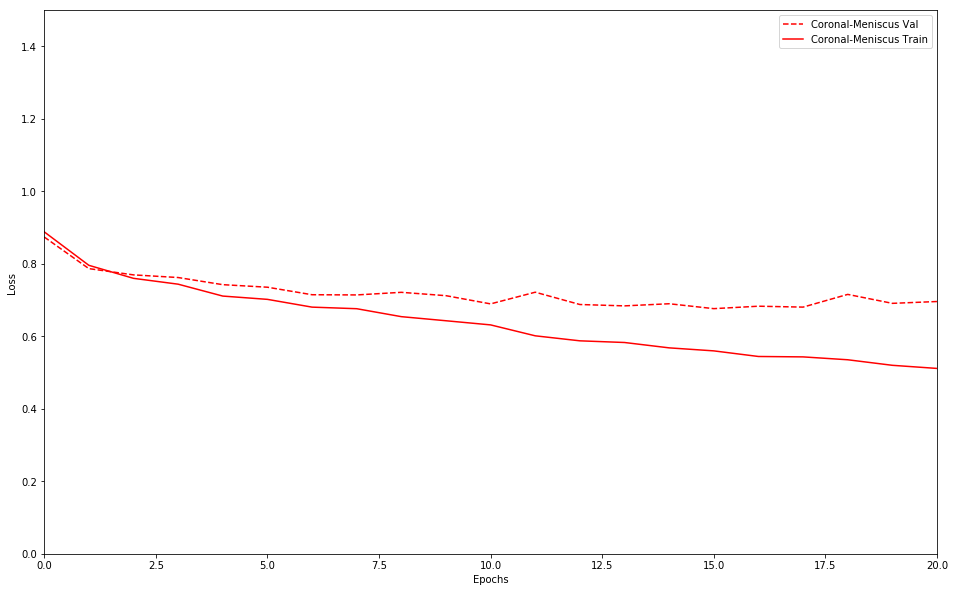

In [10]:
model = build_model()
history = train_model(model,"coronal","meniscus")
plot_history([('Coronal-Meniscus',history)])

## Model 7: Sagittal Plane and ACL Labels

Train on 1130 samples, validate on 120 samples
Epoch 1/50

Epoch 00001: val_acc improved from -inf to 0.55000, saving model to /content/gdrive/My Drive/Models/PaperImplementation/sagittal_acl.h5
 - 3s - loss: 0.7265 - acc: 0.7726 - val_loss: 1.0560 - val_acc: 0.5500
Epoch 2/50

Epoch 00002: val_acc did not improve from 0.55000
 - 0s - loss: 0.6562 - acc: 0.8053 - val_loss: 0.9500 - val_acc: 0.5500
Epoch 3/50

Epoch 00003: val_acc did not improve from 0.55000
 - 0s - loss: 0.6480 - acc: 0.8062 - val_loss: 0.9001 - val_acc: 0.5500
Epoch 4/50

Epoch 00004: val_acc did not improve from 0.55000
 - 0s - loss: 0.6033 - acc: 0.8150 - val_loss: 1.0090 - val_acc: 0.5500
Epoch 5/50

Epoch 00005: val_acc did not improve from 0.55000
 - 0s - loss: 0.5688 - acc: 0.8124 - val_loss: 0.9243 - val_acc: 0.5500
Epoch 6/50

Epoch 00006: val_acc did not improve from 0.55000
 - 0s - loss: 0.5619 - acc: 0.8150 - val_loss: 0.9143 - val_acc: 0.5500
Epoch 7/50

Epoch 00007: val_acc did not improve from 0.55000
 

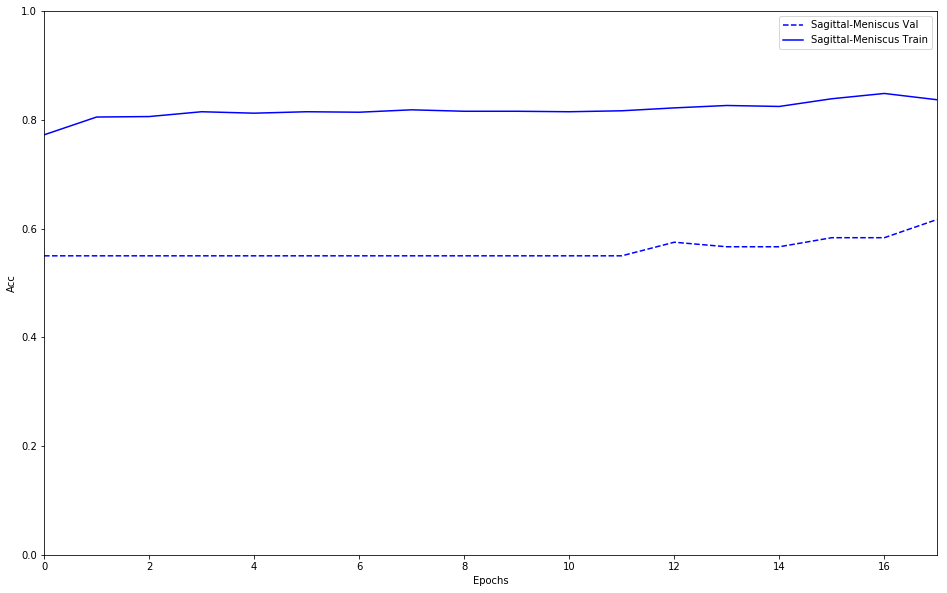

<Figure size 432x288 with 0 Axes>

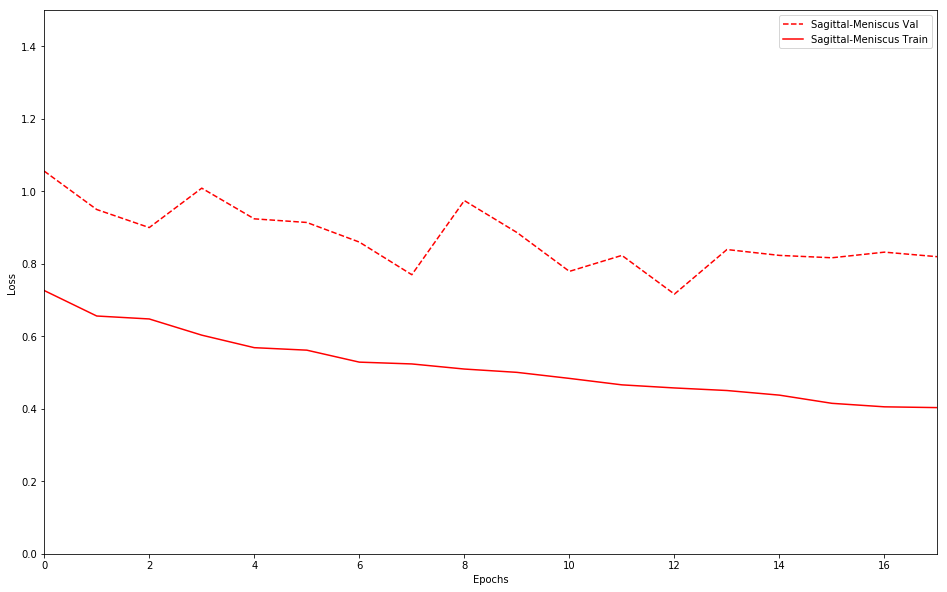

In [11]:
model = build_model()
history = train_model(model,"sagittal","acl")
plot_history([('Sagittal-Meniscus',history)])

## Model 8: Sagittal Plane and Abnormal Labels

Train on 1130 samples, validate on 120 samples
Epoch 1/50

Epoch 00001: val_acc improved from -inf to 0.79167, saving model to /content/gdrive/My Drive/Models/PaperImplementation/sagittal_abnormal.h5
 - 3s - loss: 0.7353 - acc: 0.7442 - val_loss: 0.6650 - val_acc: 0.7917
Epoch 2/50

Epoch 00002: val_acc improved from 0.79167 to 0.80000, saving model to /content/gdrive/My Drive/Models/PaperImplementation/sagittal_abnormal.h5
 - 0s - loss: 0.6277 - acc: 0.8044 - val_loss: 0.5915 - val_acc: 0.8000
Epoch 3/50

Epoch 00003: val_acc improved from 0.80000 to 0.80833, saving model to /content/gdrive/My Drive/Models/PaperImplementation/sagittal_abnormal.h5
 - 0s - loss: 0.5861 - acc: 0.8035 - val_loss: 0.5552 - val_acc: 0.8083
Epoch 4/50

Epoch 00004: val_acc did not improve from 0.80833
 - 0s - loss: 0.5480 - acc: 0.8097 - val_loss: 0.5231 - val_acc: 0.8083
Epoch 5/50

Epoch 00005: val_acc did not improve from 0.80833
 - 0s - loss: 0.5230 - acc: 0.8168 - val_loss: 0.5232 - val_acc: 0.7833
Epoc

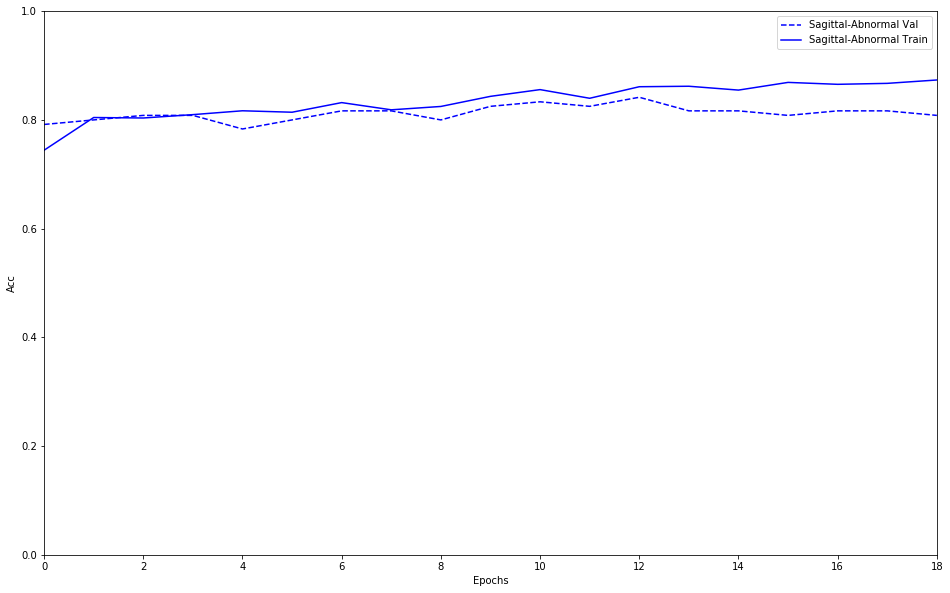

<Figure size 432x288 with 0 Axes>

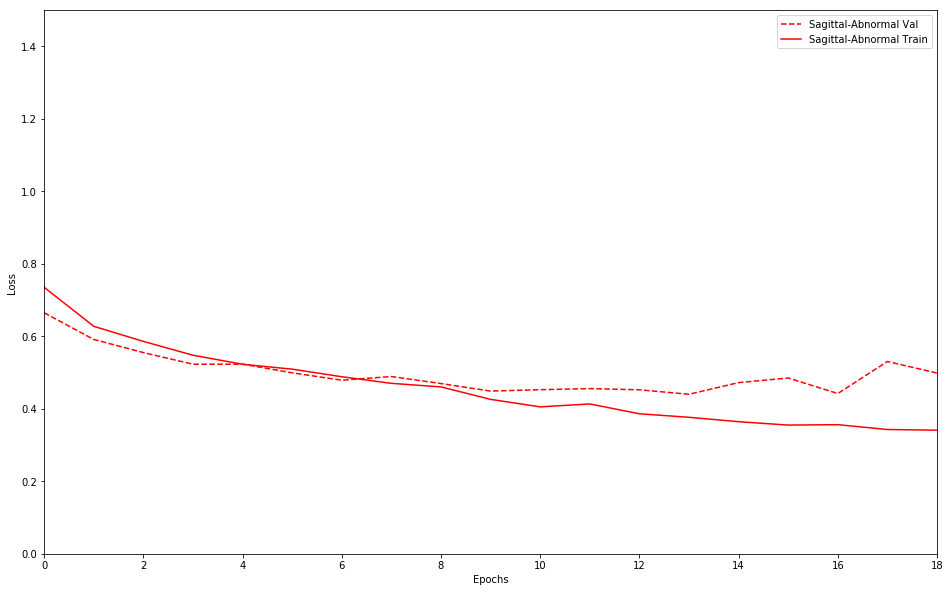

In [12]:
model = build_model()
history = train_model(model,"sagittal","abnormal")
plot_history([('Sagittal-Abnormal',history)])

## Model 9: Sagittal Plane and Meniscus Labels

Train on 1130 samples, validate on 120 samples
Epoch 1/50

Epoch 00001: val_acc improved from -inf to 0.58333, saving model to /content/gdrive/My Drive/Models/PaperImplementation/sagittal_meniscus.h5
 - 3s - loss: 0.8850 - acc: 0.5681 - val_loss: 0.8194 - val_acc: 0.5833
Epoch 2/50

Epoch 00002: val_acc improved from 0.58333 to 0.60833, saving model to /content/gdrive/My Drive/Models/PaperImplementation/sagittal_meniscus.h5
 - 0s - loss: 0.7956 - acc: 0.6389 - val_loss: 0.7897 - val_acc: 0.6083
Epoch 3/50

Epoch 00003: val_acc did not improve from 0.60833
 - 0s - loss: 0.7794 - acc: 0.6389 - val_loss: 0.7865 - val_acc: 0.5667
Epoch 4/50

Epoch 00004: val_acc improved from 0.60833 to 0.61667, saving model to /content/gdrive/My Drive/Models/PaperImplementation/sagittal_meniscus.h5
 - 0s - loss: 0.7538 - acc: 0.6558 - val_loss: 0.7508 - val_acc: 0.6167
Epoch 5/50

Epoch 00005: val_acc did not improve from 0.61667
 - 0s - loss: 0.7290 - acc: 0.6566 - val_loss: 0.7501 - val_acc: 0.5917
Epoc

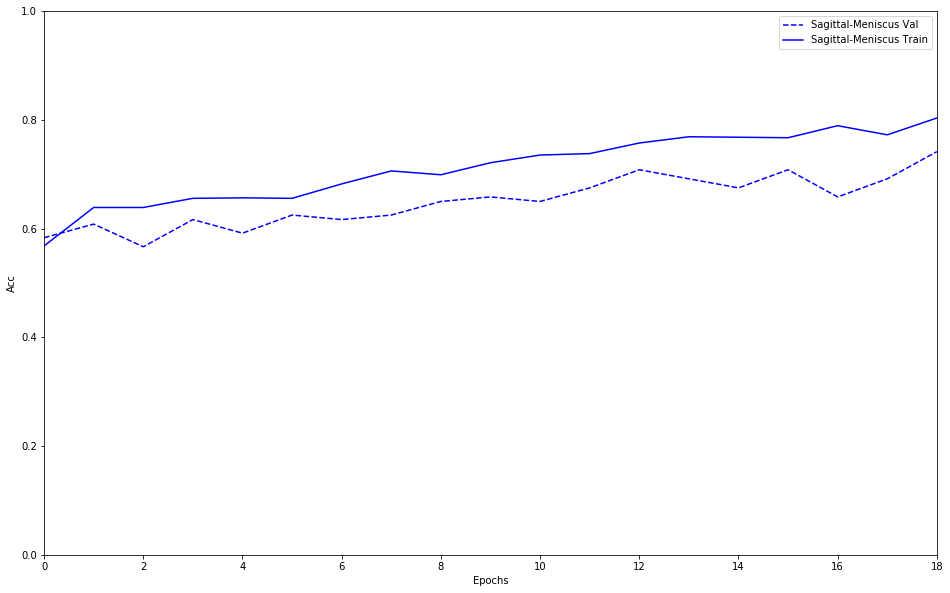

<Figure size 432x288 with 0 Axes>

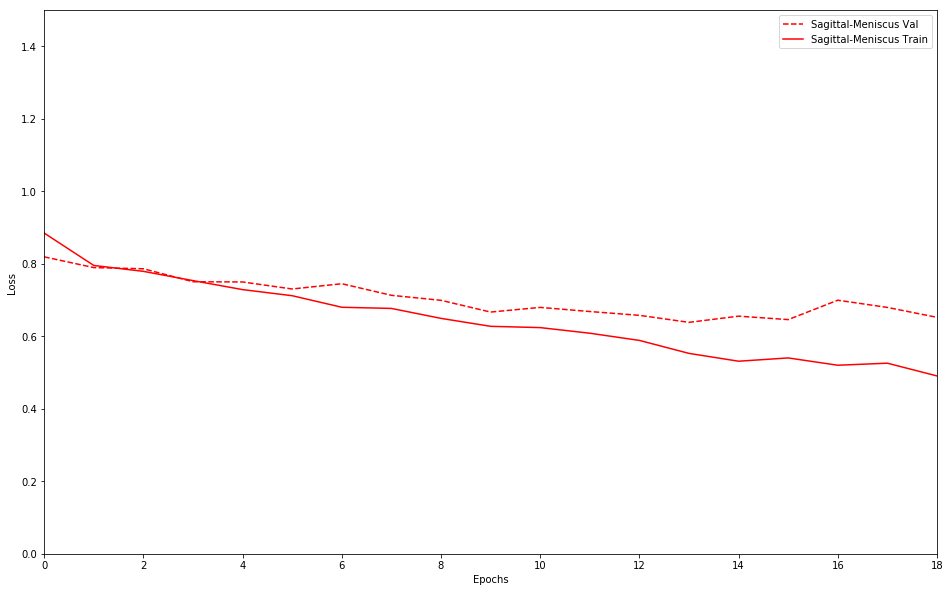

In [13]:
model = build_model()
history = train_model(model,"sagittal","meniscus")
plot_history([('Sagittal-Meniscus',history)])